# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [7]:
import time 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from LANAM.models import LaNAM, BayesianLinearRegression

from LANAM.config.default import defaults

from LANAM.trainer.training import *
from LANAM.trainer.marglik_training import *

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset

from LANAM.utils.plotting import * 

import matplotlib.pyplot as plt 
import numpy as np


from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

from nam.config import defaults as namDefaults
from nam.models import NAM, get_num_units
from nam.trainer import LitNAM
from nam.utils import *
"""
Reference:
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\nReference:\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [8]:
%reload_ext autoreload 
%autoreload 2

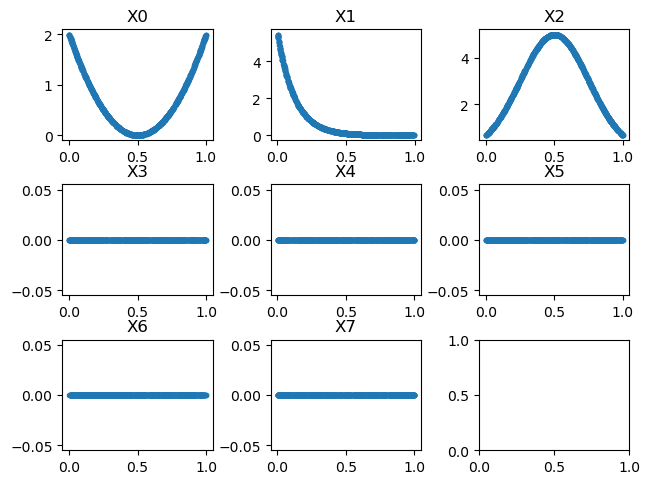

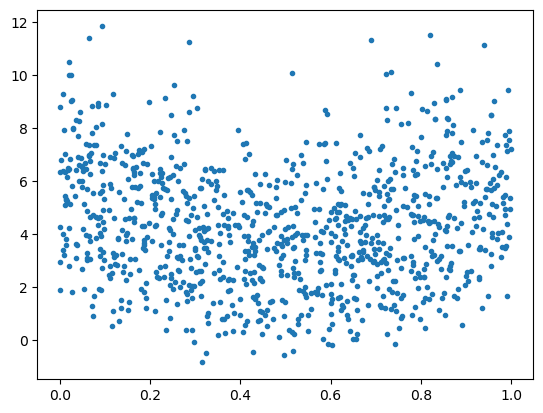

In [9]:
cfg = defaults()

gen_funcs, gen_func_names = sparse_task()
in_features = len(gen_funcs)
sigma = 1.0

trainset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=1000, 
                    sigma=sigma)
valset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=200, 
                    sigma=sigma)
testset = ToyDataset(gen_funcs, 
                    gen_func_names, 
                    num_samples=50, 
                    use_test=True)
trainset.plot()

In [10]:
model = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full')
start = time.time()
model, margliks, losses = marglik_training(model, trainset.loader, trainset.loader_fnn, 'regression', n_epochs=400, optimizer_kwargs={'lr': 1e-2})
end = time.time()
print(f'Training time: {end-start:.3f}s')

EPOCH=1: epoch_loss= 10.076, epoch_perf= 9.739
EPOCH=51: epoch_loss= 1.182, epoch_perf= 1.176
EPOCH=101: epoch_loss= 1.114, epoch_perf= 1.108
EPOCH=151: epoch_loss= 1.140, epoch_perf= 1.134
EPOCH=201: epoch_loss= 1.150, epoch_perf= 1.144
EPOCH=251: epoch_loss= 1.095, epoch_perf= 1.089
EPOCH=301: epoch_loss= 1.069, epoch_perf= 1.063
EPOCH=351: epoch_loss= 1.054, epoch_perf= 1.048
MARGLIK: finished training. Recover best model and fit Laplace.
Training time: 59.692s


In [13]:
print(model.additive_sigma_noise)

tensor(1.0521, grad_fn=<SqrtBackward0>)


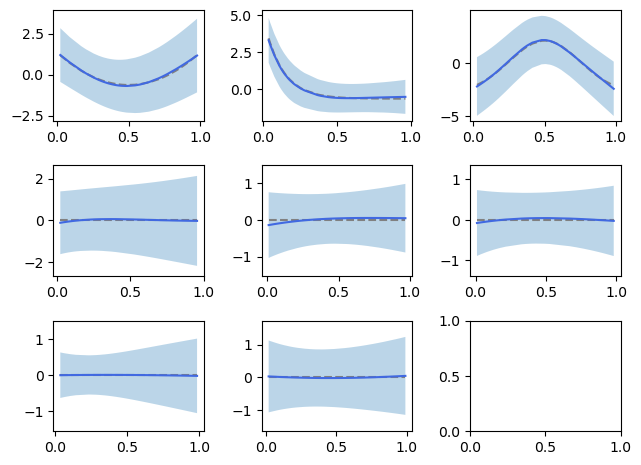

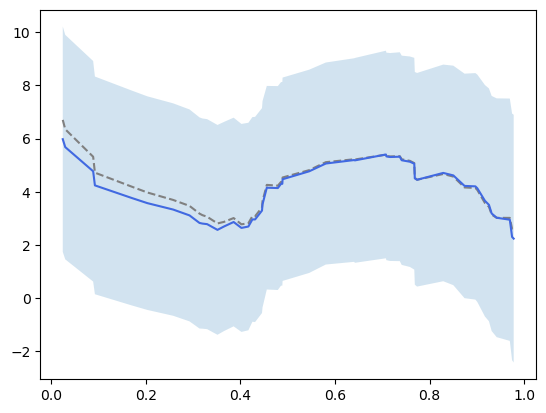

In [11]:
plot_predictive_posterior(model, testset)

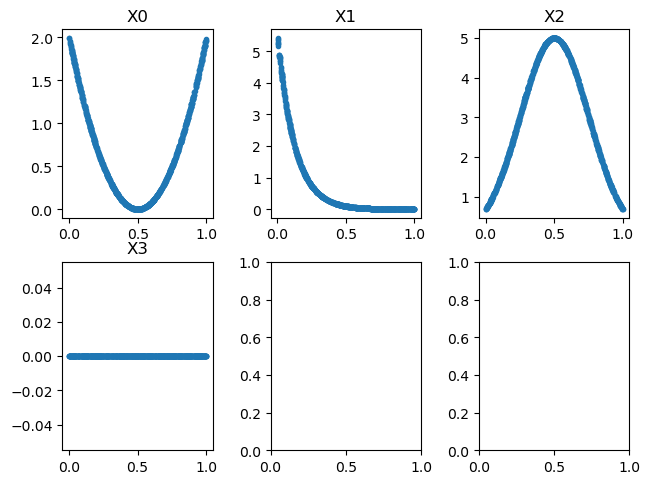

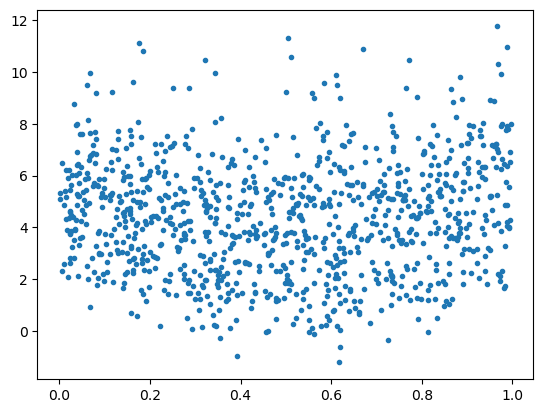

In [12]:
cfg = defaults()

gen_funcs, gen_func_names = task()
in_features = len(gen_funcs)
sigma = 1.0

trainset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=1000, 
                    sigma=sigma)
valset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=200, 
                    sigma=sigma)
testset = ToyDataset(gen_funcs, 
                    gen_func_names, 
                    num_samples=50, 
                    use_test=True)
trainset.plot()

In [8]:
model_ph = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full')
print(model_ph)

LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)


In [9]:
loss = train(cfg, model_ph, trainset.loader, valset.loader)
model_ph.fit(loss, trainset.loader_fnn)

=============EPOCH 1==============
loss_train:  9.125, loss_val:  5.947
=============EPOCH 101==============
loss_train:  1.122, loss_val:  1.142
=============EPOCH 201==============
loss_train:  1.043, loss_val:  1.008
=============EPOCH 301==============
loss_train:  1.047, loss_val:  1.060
Finished Training.


In [10]:
print(f'prior_precision: {model_ph.prior_precision}, sigma_noise: {model_ph.sigma_noise}')

prior_precision: tensor([1., 1., 1., 1.]), sigma_noise: tensor([1., 1., 1., 1.])


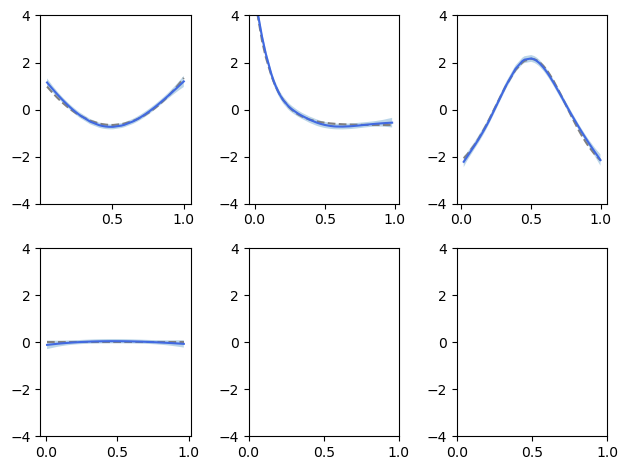

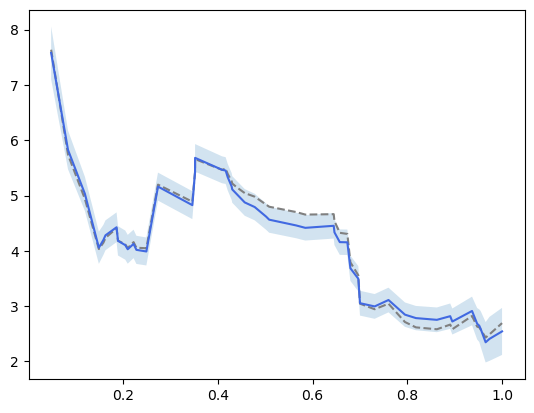

In [11]:
plot_predictive_posterior(model_ph, testset)

In [12]:
# la-nam
n_epochs = 1000
log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - model_ph.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
print(f'Finish post-hoc hyperparameter tuning. prior_precision: {model_ph.prior_precision}, sigma_noise: {model_ph.sigma_noise}')

Finish post-hoc hyperparameter tuning. prior_precision: tensor([0.0556, 0.0338, 0.0350, 0.0993], grad_fn=<ExpBackward0>), sigma_noise: tensor([0.4860, 0.5694, 0.5893, 0.4132], grad_fn=<ExpBackward0>)


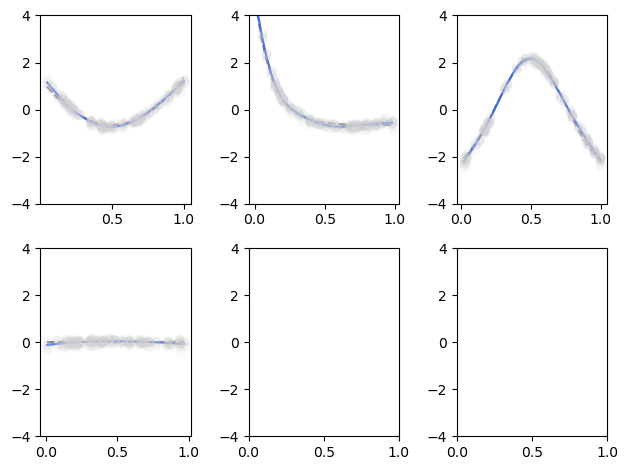

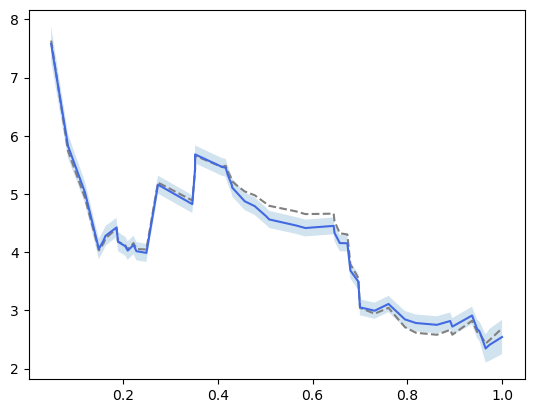

In [31]:
plot_predictive_posterior(model_ph, testset, sampling=True)

In [32]:
model_ol = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full')
start = time.time()
model_ol, margliks, losses = marglik_training(model_ol, trainset.loader, trainset.loader_fnn, 'regression', n_epochs=400, optimizer_kwargs={'lr': 1e-2})
end = time.time()
print(f'Training time: {end-start:.3f}s')

EPOCH=1: epoch_loss= 7.806, epoch_perf= 7.634
EPOCH=51: epoch_loss= 1.175, epoch_perf= 1.168
EPOCH=101: epoch_loss= 1.189, epoch_perf= 1.182
EPOCH=151: epoch_loss= 1.088, epoch_perf= 1.081
EPOCH=201: epoch_loss= 1.090, epoch_perf= 1.084
EPOCH=251: epoch_loss= 1.055, epoch_perf= 1.048
EPOCH=301: epoch_loss= 1.049, epoch_perf= 1.042
EPOCH=351: epoch_loss= 1.039, epoch_perf= 1.032
MARGLIK: finished training. Recover best model and fit Laplace.
Training time: 33.811s


In [33]:
print(f'prior_precision: {model_ol.prior_precision}, sigma_noise: {model_ol.sigma_noise}')

prior_precision: tensor([0.0670, 0.0501, 0.0464, 0.1607], grad_fn=<ExpBackward0>), sigma_noise: tensor([0.4823, 0.5915, 0.5764, 0.4164], grad_fn=<ExpBackward0>)


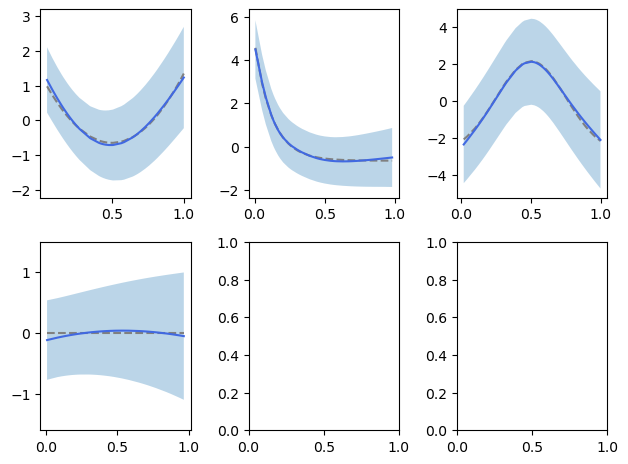

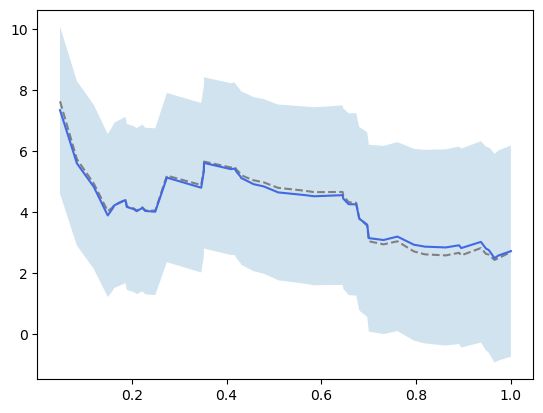

In [67]:
plot_predictive_posterior(model_ol, testset)